<a href="https://colab.research.google.com/github/andreabioddo/AdvancedCpp-C/blob/main/NEW%20LocalSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch


## Imports

In [ ]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR, LambdaLR
import matplotlib.pyplot as plt
import copy
import time
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast
import os
from google.colab import drive
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.optim.lr_scheduler")
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Early stopping

In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='/content/drive/MyDrive/Early2checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer=None):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss_min': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss



## Function to get train, test and val dataset

In [ ]:
def get_dataset(batch_size):
    batch_size=batch_size
    print("batch_size", batch_size)
    # Define the transform to only convert the images to tensors (without normalization yet)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    print("Mean: ", mean)
    print("Std: ", std)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

# LocalSGD

batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5070, 0.4865, 0.4408])
Std:  tensor([0.2664, 0.2555, 0.2750])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.79 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 9: in

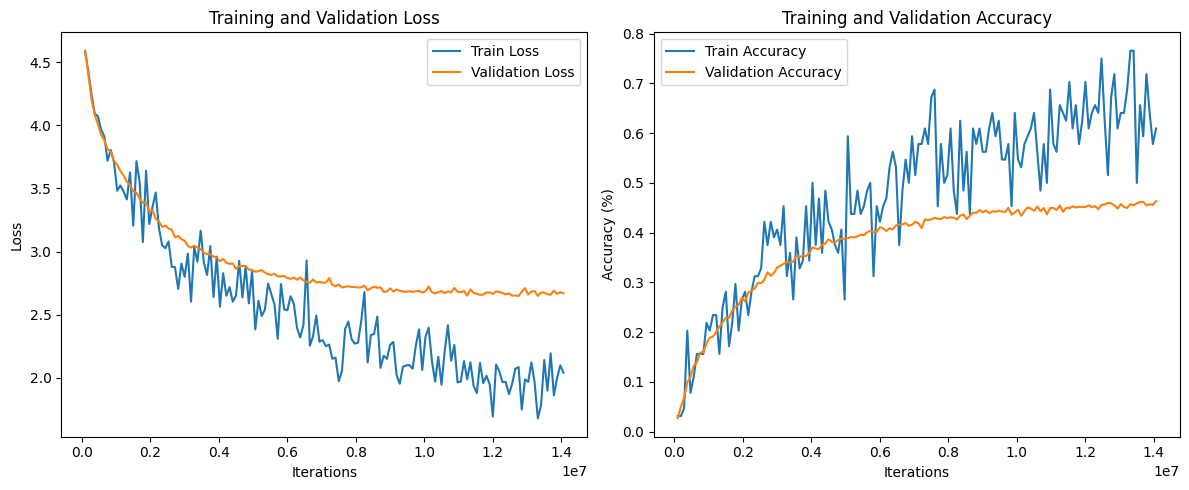

Running LocalSGD with 1 workers and 4 local steps
Worker 0: Label Distribution - {0: 393, 1: 388, 2: 387, 3: 394, 4: 395, 5: 391, 6: 400, 7: 400, 8: 390, 9: 389, 10: 393, 11: 386, 12: 404, 13: 403, 14: 383, 15: 402, 16: 400, 17: 403, 18: 410, 19: 421, 20: 416, 21: 393, 22: 403, 23: 396, 24: 401, 25: 407, 26: 399, 27: 409, 28: 404, 29: 397, 30: 415, 31: 399, 32: 406, 33: 411, 34: 395, 35: 399, 36: 394, 37: 403, 38: 393, 39: 397, 40: 398, 41: 411, 42: 400, 43: 399, 44: 401, 45: 398, 46: 403, 47: 399, 48: 389, 49: 396, 50: 407, 51: 402, 52: 407, 53: 393, 54: 385, 55: 408, 56: 401, 57: 411, 58: 391, 59: 406, 60: 391, 61: 406, 62: 387, 63: 385, 64: 399, 65: 399, 66: 394, 67: 401, 68: 405, 69: 388, 70: 419, 71: 418, 72: 391, 73: 400, 74: 418, 75: 387, 76: 403, 77: 413, 78: 409, 79: 401, 80: 403, 81: 404, 82: 391, 83: 412, 84: 397, 85: 402, 86: 411, 87: 394, 88: 401, 89: 411, 90: 405, 91: 404, 92: 405, 93: 400, 94: 399, 95: 400, 96: 396, 97: 394, 98: 392, 99: 391}
Epoch 1/150 | Train Loss: 4.

In [ ]:
def split_cifar100(dataset, num_workers):
    indices = np.random.permutation(len(dataset))
    splits = np.array_split(indices, num_workers)
    return [torch.utils.data.Subset(dataset, split) for split in splits]


def local_sgd(train_dataset, val_loader, test_loader, device, num_workers, local_steps, num_epochs, batch_size, hyperparams):
    dataset_size = len(train_dataset)
    datasets = split_cifar100(train_dataset, num_workers)
    workers = [
        torch.utils.data.DataLoader(
            datasets[i],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )
        for i in range(num_workers)
    ]

    total_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * local_steps)
    iterations_per_epoch = total_iterations // num_epochs

    global_model = LeNet5().to(device)
    local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
    local_optimizers = [
        optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams['momentum'],
        )
        for model in local_models
    ]

    schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]
    criterion = nn.CrossEntropyLoss()
    local_weights = [len(datasets[i].indices) / dataset_size for i in range(num_workers)]

    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []
    #best_val_acc = 0.0
    #best_model_state = None

    worker_iters = [iter(workers[i]) for i in range(num_workers)]

    for iteration in range(1, total_iterations + 1):
        # Local training for H steps
        for worker_id in range(num_workers):
            local_models[worker_id].train()
            for _ in range(local_steps):
                try:
                    inputs, labels = next(worker_iters[worker_id])
                except StopIteration:
                    worker_iters[worker_id] = iter(workers[worker_id])
                    inputs, labels = next(worker_iters[worker_id])

                inputs, labels = inputs.to(device), labels.to(device)
                local_optimizers[worker_id].zero_grad()
                outputs = local_models[worker_id](inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizers[worker_id].step()

        # Model averaging after H steps
        with torch.no_grad():
            global_state_dict = global_model.state_dict()
            for key in global_state_dict.keys():
                global_state_dict[key] = torch.sum(
                    torch.stack([
                        local_weights[i] * local_models[i].state_dict()[key]
                        for i in range(num_workers)
                    ]),
                    dim=0
                )

            global_model.load_state_dict(global_state_dict)
            # Update local models with averaged weights
            for local_model in local_models:
                local_model.load_state_dict(global_state_dict)

        if iteration % iterations_per_epoch == 0:
            # Global metrics calculation
            global_model.eval()
            global_train_loss, global_correct, global_total = 0.0, 0, 0
            with torch.no_grad():
                # Train on the global model after local updates
                for inputs, labels in workers[0]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = global_model(inputs)
                    loss = criterion(outputs, labels)
                    global_train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    global_correct += predicted.eq(labels).sum().item()
                    global_total += labels.size(0)

            global_train_loss /= len(workers[0])
            global_train_acc = global_correct / global_total
            train_losses.append(global_train_loss)
            train_accuracies.append(global_train_acc)


            # Validation
            global_model.eval()
            val_loss, correct, total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = global_model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    correct += predicted.eq(labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            #if val_acc > best_val_acc:
                #best_val_acc = val_acc
                #best_model_state = copy.deepcopy(global_model.state_dict())

            print(f"Iteration {iteration} / {total_iterations} -> {(iteration/total_iterations)*100:.2f}% | Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_acc * 100:.2f}%  | Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

            # Step schedulers after each epoch
            for scheduler in schedulers:
                scheduler.step()

    # Ripristina il miglior modello
    #if best_model_state:
        # global_model.load_state_dict(best_model_state)

    # Valutazione finale sul test set
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, total_iterations, iterations_per_epoch



# Visualization function
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations):
    # Dynamic calculation record points
    recorded_iterations = len(train_losses)
    iterations = range(iterations_per_epoch, iterations_per_epoch * recorded_iterations + 1, iterations_per_epoch)

    # Ensure data length is consistent
    assert len(train_losses) == len(iterations), f"Train losses and iterations mismatch: {len(train_losses)} vs {len(iterations)}"
    assert len(val_losses) == len(iterations), f"Validation losses and iterations mismatch: {len(val_losses)} vs {len(iterations)}"

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(iterations, train_losses, label="Train Loss")
    plt.plot(iterations, val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iterations, train_accuracies, label="Train Accuracy")
    plt.plot(iterations, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = 150
    batch_size = 64
    num_workers_list = [2, 4, 8]
    local_steps_list = [4, 8, 16, 32, 64]
    hyperparams = {
        'lr': 0.01,
        'weight_decay': 0.001,
        'momentum': 0.9,
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)
    train_dataset = train_loader.dataset

    for num_workers in num_workers_list:
        for local_steps in local_steps_list:
            print(f"Running LocalSGD with {num_workers} workers and {local_steps} local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc, total_iterations, iterations_per_epoch = local_sgd(
                train_dataset=train_dataset,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                local_steps=local_steps,
                num_epochs=num_epochs,
                batch_size=batch_size,
                hyperparams=hyperparams,
            )

            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations)
